# The fundamental operation of ApRES
This ppage describes the fundemental operation of the Autonomous Radio-echo sounder, including 
- a description of the linear chirps the system emits, 
- how individual and multiple reflectors are represented in the returned signal,
- how the range to these reflectors is encoded in the frequency content of returned signal, and 
- how to extract the range to reflectors using a fourier transform. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from numpy.random import default_rng

#%matplotlib widget

Define a function which returns a sawtooth signal with a period of 1 s. So that we can demonstrate what it looks like when the return is delayed by a given time, we add to the function an optional delay in seconds. The bandwidth $B$ the center frequency $f_c$ are set by the radar.

In [7]:
t_sawtooth = np.linspace(0,3,900)
def sawtooth_with_delay(delay = 0):
    B = 200e6      # bandwidth
    f_c = 300e6 3  # center frequency
    return (scipy.signal.sawtooth(2*np.pi*(t_sawtooth-delay))+1)/2 * B + (f_c-B/2)


Next we use this function to create two sawtooth signals: one with zero delay and the other with a delay of 0.1 s.

In [10]:
tx = sawtooth_with_delay()
rx = sawtooth_with_delay(delay = 0.1)

A delay of 0.1s says that it took the radio waves 0.1s to travel from the radar, to some reflector, and back to the radar. This is the 'two-way travel time', often shortened to TWTT, but we will use $T$. To compute the range $R$, from the TWTT we use 

$$
T = 2R\frac{\sqrt\epsilon}{c},
$$

$$
R = \frac{cT}{2\sqrt\epsilon}
$$

where $c$ is the speed of light in a vacuum and $\epsilon$ is the dialectric constant of ice.


In [12]:
def range_to_reflector(T):
    ep = 3.1
    c = 299792458
    return c*T/2/ep**0.5

Let's quickly use this function to compute how deep in the ice a reflector would need to be to cause a delay of 0.1s in the return of the radio-wave. 

In [26]:
print(f"Depth to refletor in ice: ~{range_to_reflector(0.1)/1e3:.0f} km")

Depth to refletor in ice: ~8514 km


This is obvious MUCH deeper than any ice we will ever encounter; we choose 0.1s purely so that we can see the delay in the plots below. 

## Plotting the frequency ramps and returns
Let's first plot the frequency of the transmitted signal as a function of time. 

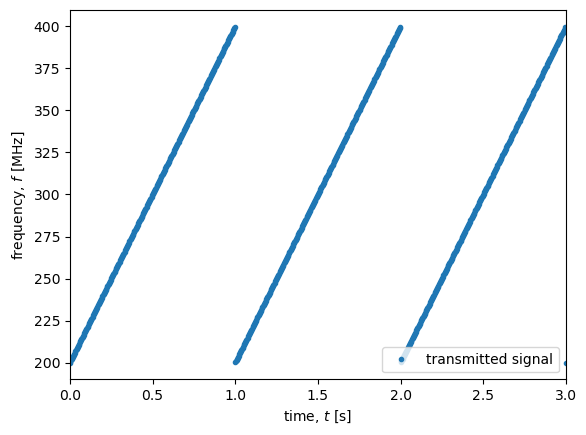

In [28]:
fig, ax = plt.subplots()
ax.plot(t_sawtooth,tx/1e6,'.', label ='transmitted signal')
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
ax.legend()
ax.set_xlim(0, 3);

Then we can add to the plot the returned signal after a delay of 0.1s (as resulting from a reflection from a ~9000 km deep reflector)

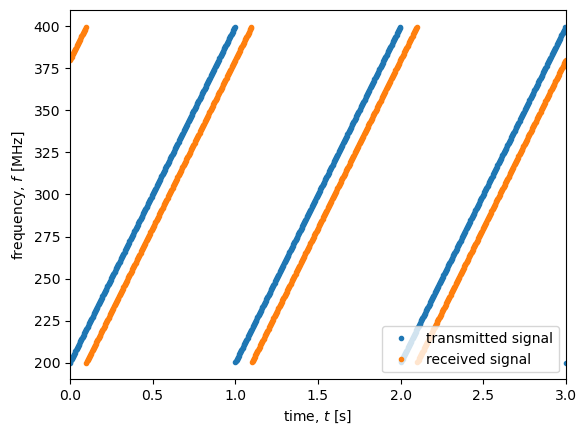

In [29]:
fig, ax = plt.subplots()
ax.plot(t_sawtooth,tx/1e6,'.C0', label ='transmitted signal')
ax.plot(t_sawtooth,rx/1e6,'.C1', label ='received signal')
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
ax.legend()
ax.set_xlim(0, 3);

In orange above is the frequency of a signal received from a single reflector as a function of time. But in general we simultaneously receive signals from a whole range of depth. To give a feel for what this looks like, below is plotted the frequency of ten signals with random delays (i.e. depths).

The time delays associated with these signals are [0.05030683 0.13084193 0.10330119 0.06233049 0.0591932  0.13744466
 0.05530811 0.13759185 0.10054563 0.07625694] s


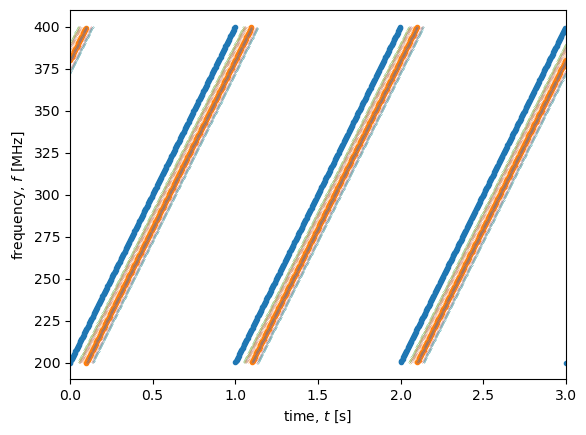

In [30]:
# plot the same transmitted and received signals we plotted above
fig, ax = plt.subplots()
#t = np.linspace(0,3,900)
ax.plot(t_sawtooth,tx/1e6,'.', label ='transmitted signal')
ax.plot(t_sawtooth,rx/1e6,'.', label ='received signal')

# produce some randomly delayed signals
rng = default_rng(seed = 4321)
delays = np.absolute(rng.uniform(0.05, 0.15, 10))


print(f"The time delays associated with these signals are {delays} s")
for delay in delays:
    rx_rnd = sawtooth_with_delay(delay)
    ax.plot(t_sawtooth,rx_rnd/1e6,'.', label ='received signal', markersize = 0.3)

# finish off the plots
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('frequency, $f$ [MHz]')
#ax.legend()
ax.set_xlim(0, 3);   

Let's construct what signal we would get if we mixed and filtered the three different signals plotted above. 

In the case when there was only one received signal, delayed by 0.1s, we use the geometry of the figure to see that

$$ 
\Delta f = K \Delta t
$$

where $K = 200 \times10^6$ Hz/s is the rate of increase in the transmitted frequency.

So the signal recorded in the chirps will have this frequency.

period of 1.0000000000000001e-07 s
frequency of 10000.0 kHz


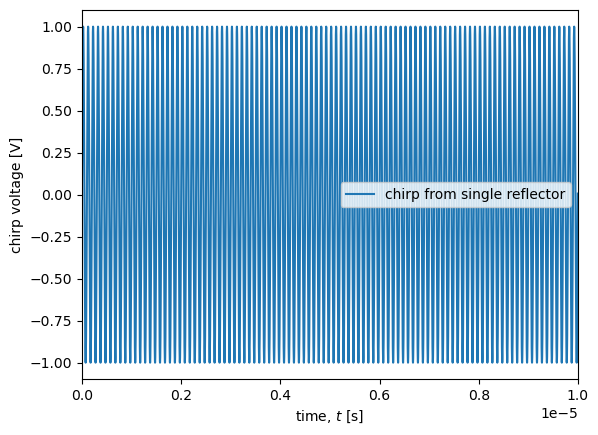

In [6]:
t = np.linspace(0.0, 1e-4, 100000)
def wave(A,omega):
    print(f"period of {2*np.pi/omega} s")
    print(f"frequency of {omega/2/np.pi/1e3} kHz")
    return A*np.sin(omega*t)
K = 100e6

chirp_1 = wave(1,2*np.pi*K*0.1)


fig, ax = plt.subplots()
ax.plot(t,chirp_1, label ='chirp from single reflector')
# finish off the plots
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('chirp voltage [V]')
ax.set_xlim(0, 1e-5)
ax.legend()

Notice that in the plot above we have only plotted out a very short section of the chirp from the very beginning, because it is quite high frequency (a consequence of choosing $\Delta t = 0.1$ for the first plot above) and the oscillations would not be visible if we plotted out the whole 1 s chirp. 

Next let's see what the chirp from the other scenario above would look like. 

We will sum together al the other signals we obtained above to make one signal. 

In [7]:
chirp_list = [wave(1,2*np.pi*K*delay) for delay in delays]
chirp_array = np.stack(chirp_list,axis=1)
chirp_2 = chirp_array.sum(axis=1)
chirp_2.shape


period of 1.987801608678434e-07 s
frequency of 5030.683120660306 kHz
period of 7.642809959916334e-08 s
frequency of 13084.19292439069 kHz
period of 9.680430850628307e-08 s
frequency of 10330.118725398417 kHz
period of 1.604351382373305e-07 s
frequency of 6233.048514102363 kHz
period of 1.689383327387361e-07 s
frequency of 5919.319693692636 kHz
period of 7.275655400007502e-08 s
frequency of 13744.466237350507 kHz
period of 1.8080531159565972e-07 s
frequency of 5530.810965533633 kHz
period of 7.267872511660287e-08 s
frequency of 13759.18466367757 kHz
period of 9.94573354295474e-08 s
frequency of 10054.562548665604 kHz
period of 1.3113559990751453e-07 s
frequency of 7625.69432484593 kHz


(100000,)

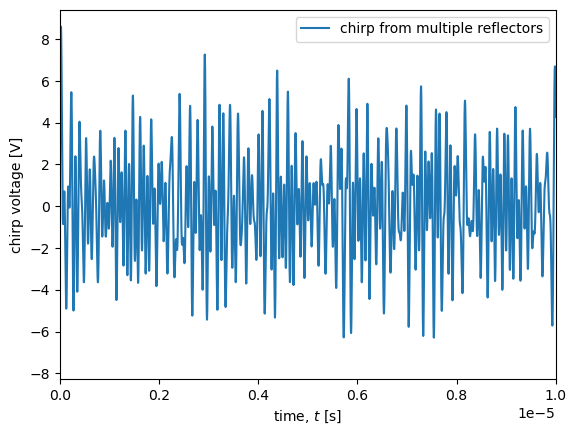

In [8]:
fig, ax = plt.subplots()

ax.plot(t, chirp_2, label ='chirp from multiple reflectors')
ax.set_xlabel('time, $t$ [s]')
ax.set_ylabel('chirp voltage [V]')
ax.set_xlim(0, 1e-5)
ax.legend()

Finally, let's check that we can extract the frequency information from the chirps and use it get the time delays we used to produce them. 



In [9]:
def chirp_fft(t,chirp):
    sampling_interval = t[1]-t[0]
    sampling_frequency = 1/ sampling_interval
    no_of_samples = len(chirp)  
    S = np.fft.fft(chirp)/no_of_samples         
    indexes = np.arange(no_of_samples) 
    frequencies  = indexes * sampling_frequency/no_of_samples
    dT = frequencies/K
    return S, frequencies, dT


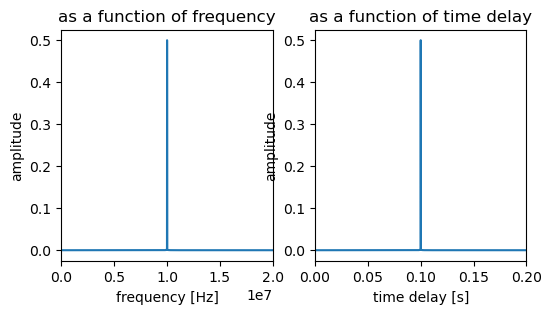

In [10]:
S, frequencies, dT = chirp_fft(t, chirp_1)
fig,ax = plt.subplots(1,2, figsize = (6,3))
ax[0].set_title('as a function of frequency')
ax[0].plot(frequencies, np.abs(S))
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('amplitude')
ax[0].set_xlim(0, 0.2e8);

ax[1].set_title('as a function of time delay')
ax[1].plot(dT, np.abs(S))
ax[1].set_xlabel('time delay [s]')
ax[1].set_ylabel('amplitude')
ax[1].set_xlim(0, 0.2);

And do the same for the multi-delay chirp

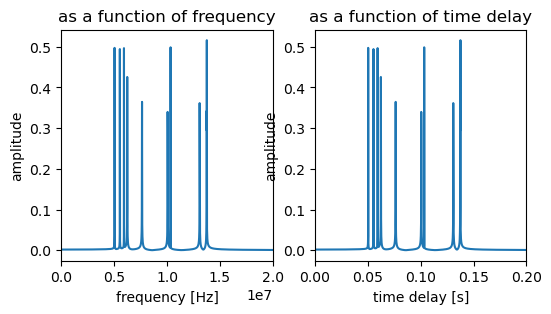

In [11]:
S, frequencies, dT = chirp_fft(t, chirp_2)
fig,ax = plt.subplots(1, 2, figsize = (6,3))
ax[0].set_title('as a function of frequency')
ax[0].plot(frequencies, np.abs(S))
ax[0].set_xlabel('frequency [Hz]')
ax[0].set_ylabel('amplitude')
ax[0].set_xlim(0, 0.2e8);

ax[1].set_title('as a function of time delay')
ax[1].plot(dT, np.abs(S))
ax[1].set_xlabel('time delay [s]')
ax[1].set_ylabel('amplitude')
ax[1].set_xlim(0, 0.2);

In [12]:
sorted_delays = np.sort(delays)
sorted_delays

array([0.05030683, 0.05530811, 0.0591932 , 0.06233049, 0.07625694,
       0.10054563, 0.10330119, 0.13084193, 0.13744466, 0.13759185])